<a href="https://colab.research.google.com/github/nunocalaim/CA_MNIST/blob/main/20201111_NC_MNIST_CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants
from IPython.display import Image, clear_output
import io
import PIL.Image, PIL.ImageDraw

import json

In [ ]:
CHANNEL_N = 19 # Number of CA state channels. It includes the 10 possible outputs but not the greyscale channel
PER_FILTERS = 80 # Number of filters to perception
CLASS_FILTERS = 80 # Number of filters of classifier (can this be diff than PER_FILTERS?)

TR_EVOLVE = 20 # Number of time steps to let CA evolve for each input
BATCH_SIZE = 16 # number of images per batch


TR_NO_ITERATIONS = 100000 # number of iterations for the training loop
TR_NO_ITERATIONS = 100000 # number of iterations for the training loop

ADD_NOISE = True # if True then the normal update of the CA has noise added
LIVING_THRESHOLD = 0.1 # the grayscale normalised minimum value for which to consider a CA alive
FR_THRESHOLD = 0.5 # update only this valyue % of ... actually I don't understad this

In [ ]:
class CAModel(tf.keras.Model):
    
    def __init__(self, channel_n=CHANNEL_N, add_noise=ADD_NOISE):
        super().__init__()
        self.channel_n = channel_n
        self.add_noise = add_noise

        self.perceive = tf.keras.Sequential([
            Conv2D(PER_FILTERS, 3, activation=tf.nn.relu, padding="SAME"), # OK here the number 3 means the size of the filter
        ]) # I still don't fully understand what this does. I guess this takes state x of CA and augments it through a conv layer

        self.dmodel = tf.keras.Sequential([
            Conv2D(CLASS_FILTERS, 1, activation=tf.nn.relu),
            Conv2D(self.channel_n, 1, activation=None, kernel_initializer=tf.zeros_initializer),
        ])
        
        self(tf.zeros([1, 3, 3, channel_n + 1])) # dummy call to build the model
    
    @tf.function
    def call(self, x):
        '''
        this function updates the CA for one cycle
        x is the current CA state. its shape is (batch_size, height, width, no_channels). 
            batch_size is BATCH_SIZE.
            height and width are 28.
            no_channels is 1 + CHANNEL_N, 
                where the first is the gray image, 
                the last 10 are the classification predictions,
                and the others are there just for fun :)
        '''
        ds = self.dmodel(self.perceive(x)) # ds will be the state update (of course, we don't want to update the gray image as that is our true input)
        gray, state = tf.split(x, [1, self.channel_n], -1)
        if self.add_noise:
            residual_noise = tf.random.normal(tf.shape(ds), mean=0., stddev=0.02)
            ds += residual_noise

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= FR_THRESHOLD # I guess this is size (batch, h, w, 1)
        living_mask = gray > LIVING_THRESHOLD # I guess this is size (batch, h, w, 1)
        residual_mask = update_mask & living_mask # I guess this is size (batch, h, w, 1)
        ds *= tf.cast(residual_mask, tf.float32) 
        state += ds

        return tf.concat([gray, state], -1)

    @tf.function
    def initialize(self, images):
        '''
        input: images of size (batch, h, w)
        output: initial CA state full of 0's for positions other than the images. shape (batch, h, w, 1 + channel_n)
        '''
        state = tf.zeros([tf.shape(images)[0], 28, 28, self.channel_n]) # size (batch, h, w, channel_n) full of zeros
        images = tf.reshape(images, [-1, 28, 28, 1]) # our images we add an extra dimension
        return tf.concat([images, state], -1) # just concatenating

    @tf.function
    def classify(self, x):
        '''
        The last 10 layers are the classification predictions, one channel
        per class. Keep in mind there is no "background" class,
        and that any loss doesn't propagate to "dead" pixels.
        '''
        return x[:, :, :, -10:]

CAModel().perceive.summary()
CAModel().dmodel.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (1, 3, 3, 80)             14480     
Total params: 14,480
Trainable params: 14,480
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (1, 3, 3, 80)             6480      
_________________________________________________________________
conv2d_98 (Conv2D)           (1, 3, 3, 19)             1539      
Total params: 8,019
Trainable params: 8,019
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training utilities

def individual_l2_loss(x, y):
    '''
    x is the current CA state vector. its shape is (batch_size, height, width, no_channels).
    y is the correct label out of 10 possibilities. its shape is (batch_size, height, width, 10) (one-hot)
    '''
    t = y - ca.classify(x) # basically we want 1's for the correct and 0s for the incorrect digit. its shape is (batch_size, height, width, 10) (one-hot)
    return tf.reduce_sum(t ** 2, [1, 2, 3]) / 2 # size batch_size

def batch_l2_loss(x, y):
    '''
    x is the current CA state vector. its shape is (batch_size, height, width, no_channels).
    y is the correct label out of 10 possibilities. its shape is (batch_size, height, width, 10) (one-hot)
    returns the mean of the loss function
    '''
    return tf.reduce_mean(individual_l2_loss(x, y))

lr = 1e-3 # initial learning rate
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([int(TR_NO_ITERATIONS*0.3), int(TR_NO_ITERATIONS*0.7)], [lr, lr*0.1, lr*0.01])
trainer = tf.keras.optimizers.Adam(lr_sched) # use ADAM optimizer with learning rate schedule

loss_log = np.zeros(TR_NO_ITERATIONS) # for plotting of loss function across time

def export_model(ca, base_fn):
    '''
    Saves the models parameters in file name base_fn
    '''
    ca.save_weights(base_fn)

    cf = ca.call.get_concrete_function(x = tf.TensorSpec([None, None, None, CHANNEL_N+1]))
    cf = convert_to_constants.convert_variables_to_constants_v2(cf)
    graph_def = cf.graph.as_graph_def()
    graph_json = MessageToDict(graph_def)
    graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
    model_json = {
        'format': 'graph-model',
        'modelTopology': graph_json,
        'weightsManifest': [],
    }
    with open(base_fn+'.json', 'w') as f:
        json.dump(model_json, f)

!mkdir -p train_log && rm -f train_log/*

In [ ]:
# Visualization utilities


def np2pil(a):
    # Covert Numpy array of floats into ints
    if a.dtype in [np.float32, np.float64]:
        a = np.uint8(np.clip(a, 0, 1) * 255)
    return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
    # Save numpy array a as image in the disk with filename f
    a = np.asarray(a)
    if isinstance(f, str):
        fmt = f.rsplit('.', 1)[-1].lower()
        if fmt == 'jpg':
            fmt = 'jpeg'
        f = open(f, 'wb')
    np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
    '''
    a is the array/tensor to be encoded
    fmt = fileformat
    '''
    a = np.asarray(a)
    if len(a.shape) == 3 and a.shape[-1] == 4:
        fmt = 'png'
    f = io.BytesIO()
    imwrite(f, a, fmt)
    return f.getvalue()

def imshow(a, fmt='jpeg'):
    '''
    a is the array/tensor to be plotted
    fmt = fileformat
    '''
    display(Image(data=imencode(a, fmt)))


# 
color_lookup = tf.constant([
                    [128, 0, 0], # 0
                    [230, 25, 75], # 1
                    [70, 240, 240], # 2
                    [210, 245, 60], # 3
                    [250, 190, 190], # 4
                    [170, 110, 40], # 5
                    [170, 255, 195], # 6
                    [165, 163, 159], # 7
                    [0, 128, 128], # 8
                    [128, 128, 0], # 9
                    [0, 0, 0], # This is the default for digits.
                    [255, 255, 255] # This is the background.
                    ])

def color_labels(x, output_x, dtype=tf.uint8):
    '''
    input x grayscale image: its shape is ([batch_size, ]height, width)
    input output_x: the output of the CA for the image x. its shape seems to be ([batch_size, ]height, width, 10)
    '''
    is_alive = tf.cast(x > LIVING_THRESHOLD, tf.float32) # 1 if pixel is alive, 0 if background. its shape ([b, ]h, w)
    is_background = 1. - is_alive # 0 if pixel is alive, 1 if background. its shape ([b, ]h, w)
    output_x = output_x * tf.expand_dims(is_alive, -1) # forcibly cancels everything outside of it. y_pic will be 0 for dead pixels. and the previous value for the alive pixels
    
    black_and_bg = tf.fill(list(x.shape) + [2], 0.01) # an array filled with 0.01 of shape ([b, ]h, w, 2). 0.01 is the minimum value for outputs to be considered
    black_and_bg *= tf.stack([is_alive, is_background], -1) # an array filled with 0.01 and 0's depending on alive status. of shape ([b, ]h, w, 2)

    number_or_background =  tf.concat([output_x, black_and_bg], -1) # the voting for the 12 different categories. (10 colors + original grayscale and background. its shape is ([b, ]h, w, 12)
    classified_pixels = tf.argmax(number_or_background, -1) # the result of the vote.  its shape is ([b, ]h, w)
    rgb_pixels = tf.gather(color_lookup, classified_pixels) # And now I suppose this shape is ([b, ]h, w, 3)
    if dtype == tf.uint8:
        return tf.cast(rgb_pixels, tf.uint8)
    else:
        return tf.cast(rgb_pixels, dtype) / 255.

def classify_and_color(ca, x):
    '''
    input ca: the CA class instance with proper architecture and learned weights
    input x: a state of the CA. its shape is (batch_size, height, width, no_channels).
    output: 
    '''
    current_image = x[:, :, :, 0]
    output_ca = ca.classify(x) # x[:, :, :, -10:] shape = (b, h, w, 10) where we want values 0 if not that number and 1 if that number
    return color_labels(current_image, output_ca, dtype=tf.float32)

def visualize_batch(ca, x0, x, step_i):
    '''
    input ca: the CA class instance with proper architecture and learned weights
    input x0: the initial state in the learning step. its shape is (batch_size, height, width, no_channels).
    input x: the final state. its shape is (batch_size, height, width, no_channels).

    '''
    vis0 = np.hstack(classify_and_color(ca, x0).numpy()) # create horizontally the batch with proper colors
    vis1 = np.hstack(classify_and_color(ca, x).numpy())
    vis = np.vstack([vis0, vis1]) # before and after the steps
    imwrite('train_log/batches_%04d.jpg'%step_i, vis)
    imshow(vis)

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()

In [ ]:
# Prepare the dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.array(x_train / 255.0,).astype(np.float32)
x_test = np.array(x_test / 255.0,).astype(np.float32)


def to_ten_dim_label(x, y):
    '''
    input x shape is (no_images, height, width)
    input y shape is (no_images,)
    output: y_res (no_images, height, width, 10) y_res[b, h, w, i] = 1 if the image b is digit i, and only at the positions h, w where it is alive
    '''
    y_res = np.zeros(list(x.shape) + [10])
    y_expanded = np.broadcast_to(y, x.T.shape).T # broadcast y to match x shape:
    y_res[x >= LIVING_THRESHOLD, y_expanded[x >= LIVING_THRESHOLD]] = 1.0 #
    return y_res.astype(np.float32)

y_train_pic = to_ten_dim_label(x_train, y_train)
# y_test_pic = to_ten_dim_label(x_test, y_test)

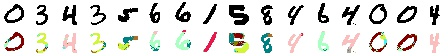

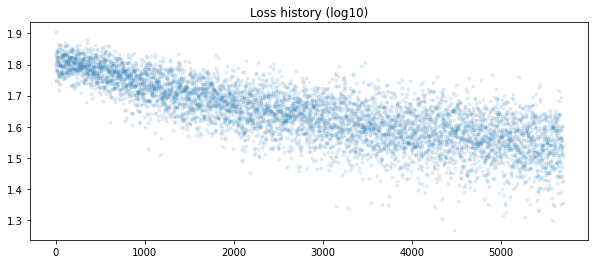

 step: 5785, log10(loss): 1.591

KeyboardInterrupt: ignored

In [ ]:
# Training happens here
ca = CAModel()

# Training Step
@tf.function
def train_step(x, y):
    '''
    x is the current CA state. its shape is (batch_size, height, width, no_channels).
    y is the correct label out of 10 possibilities. its shape is (batch_size, ?)
    '''
    iter_n = TR_EVOLVE # Number of iterations of the CA for each training step
    with tf.GradientTape() as g: # GradientTape does automatic differentiation on the learnable_parameters of our model
        for i_iter in tf.range(iter_n): # Basically let time evolve
            x = ca(x) # update the CA according to call method? ca(x) = ca.call(x)?
        loss = batch_l2_loss(x, y) # compute the scalar loss
    grads = g.gradient(loss, ca.weights) # Gradient Tape and Keras doing its magic
    grads = [g/(tf.norm(g)+1e-8) for g in grads] # Normalising the gradients uh?
    trainer.apply_gradients(zip(grads, ca.weights)) # Keras and ADAM magic 
    return x, loss

# Training Loop
for i in range(TR_NO_ITERATIONS):
#   if USE_PATTERN_POOL:
#     batch = pool.sample(BATCH_SIZE)
#     x0 = np.copy(batch.x)
#     y0 = batch.y
#     # we want half of them new. We remove 1/4 from the top and 1/4 from the
#     # bottom.
#     q_bs = BATCH_SIZE // 4

#     new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
#     x0[:q_bs] = ca.initialize(x_train[new_idx])
#     y0[:q_bs] = y_train_pic[new_idx]

#     new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
#     new_x, new_y = x_train[new_idx], y_train_pic[new_idx]
#     if MUTATE_POOL:
#       new_x = tf.reshape(new_x, [q_bs, 28, 28, 1])
#       mutate_mask = tf.cast(new_x > 0.1, tf.float32)
#       mutated_x = tf.concat([new_x, x0[-q_bs:,:,:,1:] * mutate_mask], -1)

#       x0[-q_bs:] = mutated_x
#       y0[-q_bs:] = new_y

#     else:
#       x0[-q_bs:] = ca.initialize(new_x)
#       y0[-q_bs:] = new_y

#   else:
#     b_idx = np.random.randint(0, x_train.shape[0]-1, size=BATCH_SIZE)
#     x0 = ca.initialize(x_train[b_idx])
#     y0 = y_train_pic[b_idx]

    b_idx = np.random.randint(0, x_train.shape[0] - 1, size=BATCH_SIZE)
    x0 = ca.initialize(x_train[b_idx])
    y0 = y_train_pic[b_idx]

    x, loss = train_step(x0, y0)

#   if USE_PATTERN_POOL:
#     batch.x[:] = x
#     batch.y[:] = y0 # This gets reordered, so you need to change it.
#     batch.commit()

    loss_log[i] = loss.numpy()

#   if step_i%100 == 0:
#     generate_pool_figures(ca, pool, step_i)
    if i % 100 == 0:        
        clear_output()
        visualize_batch(ca, x0, x, i)
        plot_loss(loss_log[:i])
    if i % 100 == 0:
        export_model(ca, 'train_log/%07d'%i)

    print('\r step: %d, log10(loss): %.3f'%(i + 1, np.log10(loss)), end='')